In [1]:
import os
from utils import show_all_variables
import tensorflow as tf
import argparse
from __future__ import division
import os
import time
import numpy as np
from IPython import display

from ops import *
from utils import *
#from datetime import datetime
#import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
class GAN(object):
    def __init__(self, sess, epoch, batch_size, checkpoint_dir, result_dir, log_dir):
        self.sess = sess
        self.dataset_name = 'cifar10'
        self.checkpoint_dir = checkpoint_dir
        self.result_dir = result_dir
        self.log_dir = log_dir
        self.epoch = epoch
        self.batch_size = batch_size
        self.model_name = "GAN"     # name for checkpoint
        
        # parameters for CIFAR dataset
        self.input_height = 32
        self.input_width = 32
        self.output_height = 32
        self.output_width = 32

        self.z_dim = 100         # dimension of noise-vector
        self.c_dim = 3  # color dimension

        # train
        #self.learning_rate = 0.0002 # 1e-3, 5e-4
        self.learningRateD = 1e-3
        self.learningRateG = 5e-4
        self.beta1 = 0.5

        # test
        self.sample_num = 64  # number of generated images to be saved

        # load cifar10
        self.data_X, self.data_y = load_cifar10()


        # get number of batches for a single epoch
        #print(len(self.data_X),len(self.data_y))
        #self.num_batches = self.data_X.get_shape()[0] // self.batch_size
        self.num_batches = len(self.data_X) // self.batch_size
        #print(self.num_batches)

    def discriminator(self, x, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
        with tf.variable_scope("discriminator", reuse=reuse):
            print("D:",x.get_shape()) # 32, 32, 3 = 3072
            net = lrelu(conv2d(x, 64, 5, 5, 2, 2, name='d_conv1'+'_'+self.dataset_name))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 128, 5, 5, 2, 2, name='d_conv2'+'_'+self.dataset_name), is_training=is_training, scope='d_bn2'))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 256, 5, 5, 2, 2, name='d_conv3'+'_'+self.dataset_name), is_training=is_training, scope='d_bn3'))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 512, 5, 5, 2, 2, name='d_conv4'+'_'+self.dataset_name), is_training=is_training, scope='d_bn4'))
            print("D:",net.get_shape())
            net = tf.reshape(net, [self.batch_size, -1])
            print("D:",net.get_shape())
            out_logit = linear(net, 1, scope='d_fc5'+'_'+self.dataset_name)
            print("D:",net.get_shape())
            out = tf.nn.sigmoid(out_logit)
            print("D:",out.get_shape())
            print("------------------------")
            
            return out, out_logit, net

    def generator(self, z, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
        with tf.variable_scope("generator", reuse=reuse):

            h_size = 32
            h_size_2 = 16
            h_size_4 = 8
            h_size_8 = 4
            h_size_16 = 2

            print("G:",z.get_shape())
            net = linear(z, 512*h_size_16*h_size_16, scope='g_fc1'+'_'+self.dataset_name)
            print("G:",net.get_shape())
            net = tf.nn.relu(
                bn(tf.reshape(net, [self.batch_size, h_size_16, h_size_16, 512]),is_training=is_training, scope='g_bn1')
                )
            print("G:",net.get_shape())
            net = tf.nn.relu(
                bn(deconv2d(net, [self.batch_size, h_size_8, h_size_8, 256], 5, 5, 2, 2, name='g_dc2'+'_'+self.dataset_name),is_training=is_training, scope='g_bn2')
                )
            print("G:",net.get_shape())
            net = tf.nn.relu(
                bn(deconv2d(net, [self.batch_size, h_size_4, h_size_4, 128], 5, 5, 2, 2, name='g_dc3'+'_'+self.dataset_name),is_training=is_training, scope='g_bn3')
                )
            print("G:",net.get_shape())
            net = tf.nn.relu(
                bn(deconv2d(net, [self.batch_size, h_size_2, h_size_2, 64], 5, 5, 2, 2, name='g_dc4'+'_'+self.dataset_name),is_training=is_training, scope='g_bn4')
                )
            print("G:",net.get_shape())
            out = tf.nn.tanh(
                deconv2d(net, [self.batch_size, self.output_height, self.output_width, self.c_dim], 5, 5, 2, 2, name='g_dc5'+'_'+self.dataset_name)
                )
            print("G:",out.get_shape())
            print("------------------------")
                
            return out

    def build_model(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size # 100

        """ Graph Input """
        # images
        self.inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # noises
        self.z = tf.placeholder(tf.float32, [bs, self.z_dim], name='z')

        """ Loss Function """

        # output of D for real images
        D_real, D_real_logits, _ = self.discriminator(self.inputs, is_training=True, reuse=False)

        # output of D for fake images
        G = self.generator(self.z, is_training=True, reuse=False)
        D_fake, D_fake_logits, _ = self.discriminator(G, is_training=True, reuse=True)

        # get loss for discriminator
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

        self.d_loss = d_loss_real + d_loss_fake

        # get loss for generator
        self.g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

        """ Training """
        # divide trainable variables into a group for D and a group for G
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]

        # optimizers
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_optim = tf.train.AdamOptimizer(self.learningRateD, beta1=self.beta1).minimize(self.d_loss, var_list=d_vars)
            self.g_optim = tf.train.AdamOptimizer(self.learningRateG, beta1=self.beta1).minimize(self.g_loss, var_list=g_vars)
            #self.g_optim = tf.train.AdamOptimizer(self.learning_rate*5, beta1=self.beta1).minimize(self.g_loss, var_list=g_vars)

        """" Testing """
        # for test
        self.fake_images = self.generator(self.z, is_training=False, reuse=True)

        """ Summary """
        d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
        d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
        d_loss_sum = tf.summary.scalar("d_loss", self.d_loss)
        g_loss_sum = tf.summary.scalar("g_loss", self.g_loss)

        # final summary operations
        self.g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
        self.d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

    def train(self):

        # initialize all variables
        tf.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.sample_z = np.random.uniform(-1, 1, size=(self.batch_size , self.z_dim)) # 100, 62
        self.test_images = self.data_X[0:self.batch_size]

        # saver to save model
        self.saver = tf.train.Saver()

        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '\\' + self.model_name, self.sess.graph)

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
            print(" [!] START_EPOCH is ",start_epoch," START_BATCH_ID is ", start_batch_id)
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [!] Load failed...")

        # loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)

                # update D network
                _, summary_str, d_loss = self.sess.run([self.d_optim, self.d_sum, self.d_loss],
                                               feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # update G network
                #self.sess.run([self.g_optim], feed_dict={self.inputs: batch_images, self.z: batch_z})
                # update G twice to make sure that d_loss does not go to zero
                _, _, summary_str, g_loss = self.sess.run([self.g_optim, self.g_optim, self.g_sum, self.g_loss], feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                counter += 1
                # visualize result for every 10 steps
                if np.mod(counter, 100) == 0:
                    self.visualize_results(counter)
                    print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" % (epoch, idx, self.num_batches, time.time() - start_time, d_loss, g_loss))


            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0
            # Save image
            self.visualize_results(epoch, save_fig = True)
            # save model
            self.save(self.checkpoint_dir, counter)

        # save model for final step
        self.save(self.checkpoint_dir, counter)

    def visualize_results(self, epoch, save_fig=False):
        tot_num_samples = min(self.sample_num, self.batch_size) # 64, 100
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples))) # 8

        """ random condition, random noise """
        #? I think it should be 0, 1?
        z_sample = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim)) # 100, 100

        samples = self.sess.run(self.fake_images, feed_dict={self.z: z_sample})

        display_maplot_img(samples[:image_frame_dim * image_frame_dim, :, :, :],
                    self.result_dir + '/' + self.model_name + '_epoch%03d' % epoch + '_test_all_classes.png', save_fig)

    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self.dataset_name, self.batch_size,
            self.output_height, self.output_width)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [*] Success to read [{}], counter [{}]".format(ckpt_name,counter))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

cifar-10-batches-py/data_batch_1
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 10000 10000
load_cifar10 for shape: (10000, 32, 32, 3) (10000,)
cifar-10-batches-py/data_batch_2
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 20000 20000
load_cifar10 for shape: (20000, 32, 32, 3) (20000,)
cifar-10-batches-py/data_batch_3
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 30000 30000
load_cifar10 for shape: (30000, 32, 32, 3) (30000,)
cifar-10-batches-py/data_batch_4
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 40000 40000
load_cifar10 for shape: (40000, 32, 32, 3) (40000,)
cifar-10-batches-py/data_batch_5
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 50000 50000
load_cifar10 for shape: (50000, 32, 32, 3) (50000,)
cifar-10-batches-py/test_batch
load_cifar10 for temp shape: (10000, 32, 32, 3) (10000,)
load_cifar10 for len: 60000 6000

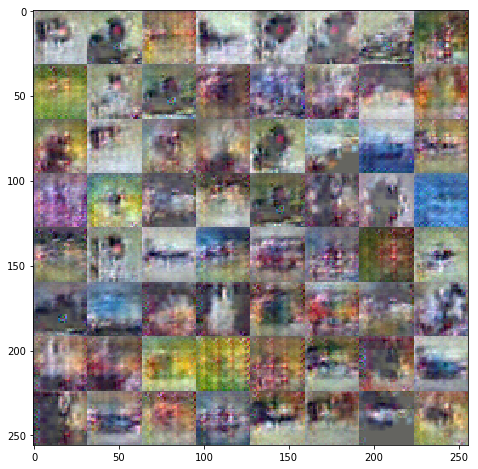

Epoch: [20] [  99/ 600] time: 30.0892, d_loss: 1.03199613, g_loss: 7.03567314


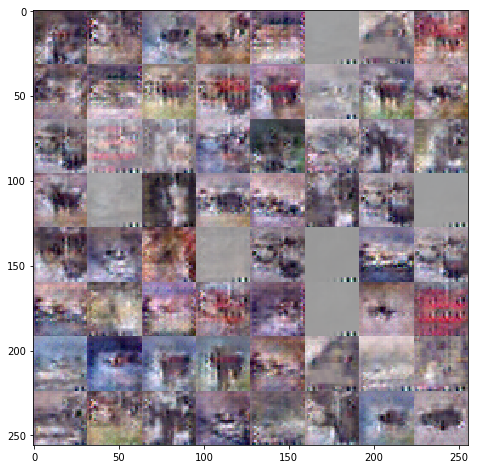

Epoch: [20] [ 199/ 600] time: 58.1586, d_loss: 0.00109159, g_loss: 9.31216049


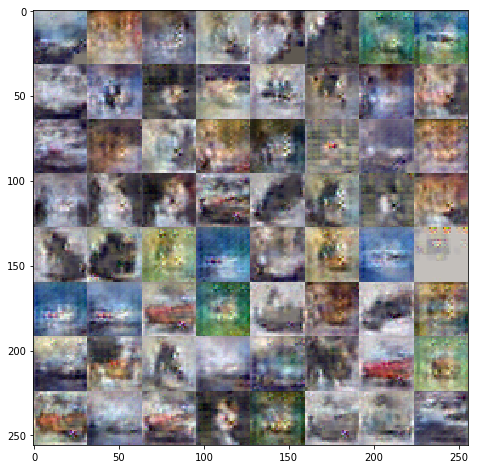

Epoch: [20] [ 299/ 600] time: 86.4050, d_loss: 0.09163429, g_loss: 5.53690243


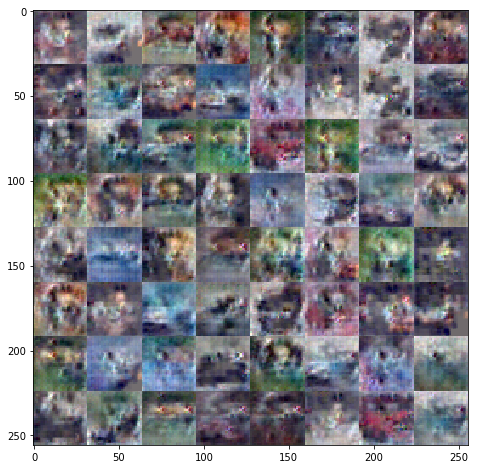

Epoch: [20] [ 399/ 600] time: 114.6778, d_loss: 0.19767068, g_loss: 6.02833366


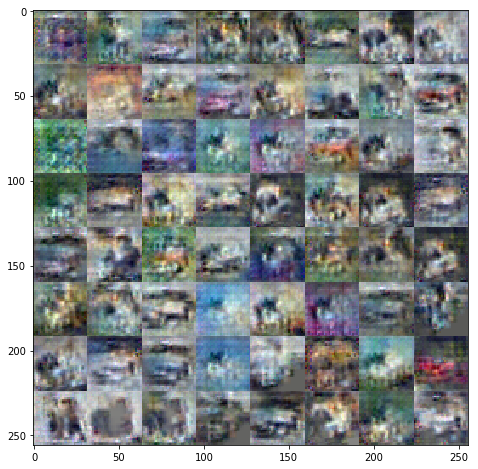

Epoch: [20] [ 499/ 600] time: 142.9549, d_loss: 0.12449833, g_loss: 5.30523062


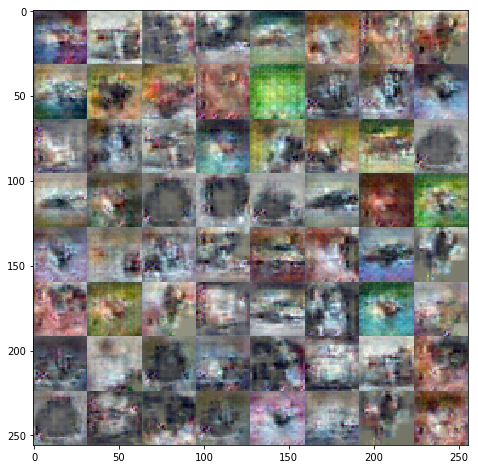

Epoch: [20] [ 599/ 600] time: 171.2744, d_loss: 0.36427748, g_loss: 5.06819534


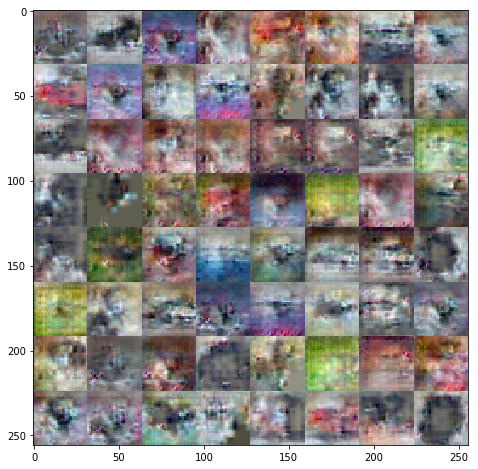

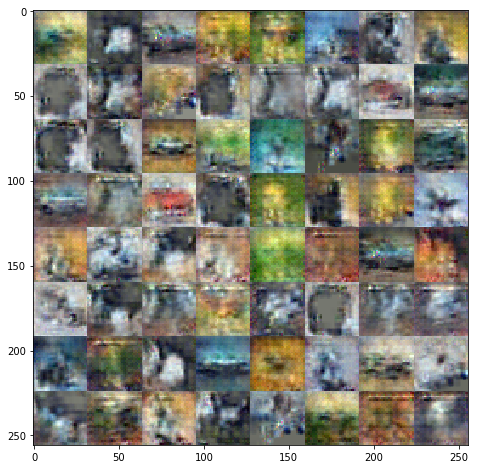

Epoch: [21] [  99/ 600] time: 200.2492, d_loss: 0.09100725, g_loss: 4.03185654


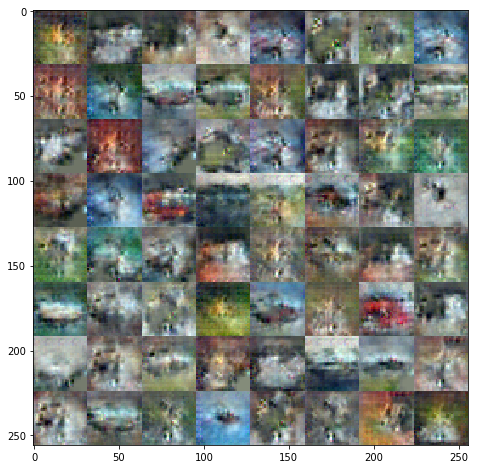

Epoch: [21] [ 199/ 600] time: 228.5839, d_loss: 0.60660625, g_loss: 7.86147833


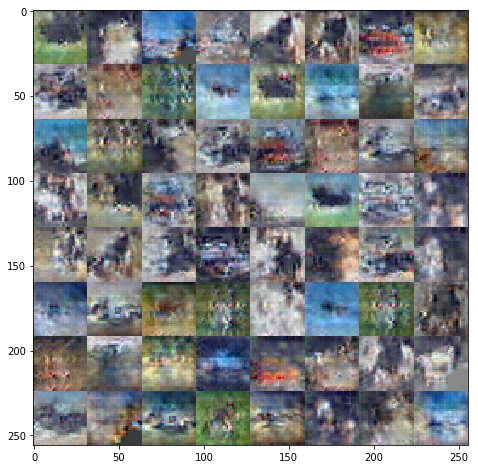

Epoch: [21] [ 299/ 600] time: 256.9568, d_loss: 0.05102282, g_loss: 5.52185249


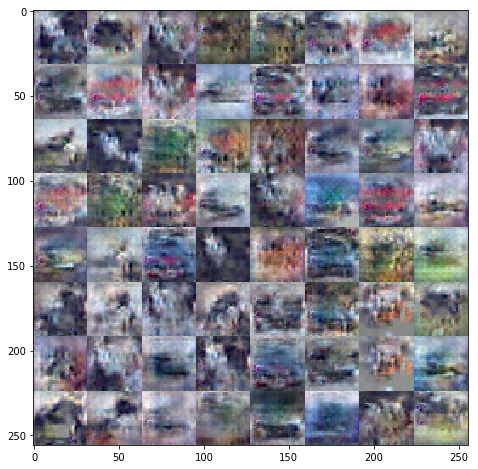

Epoch: [21] [ 399/ 600] time: 285.3272, d_loss: 0.07050028, g_loss: 5.40004349


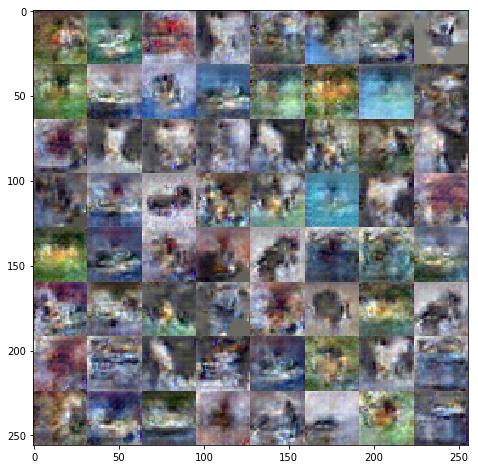

Epoch: [21] [ 499/ 600] time: 313.6574, d_loss: 0.67733169, g_loss: 5.00025272


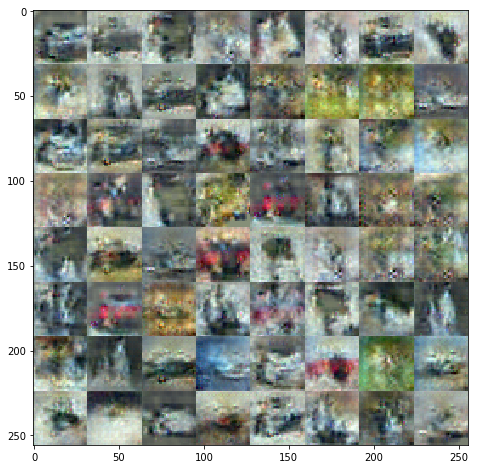

Epoch: [21] [ 599/ 600] time: 341.9899, d_loss: 0.03606888, g_loss: 8.05787563


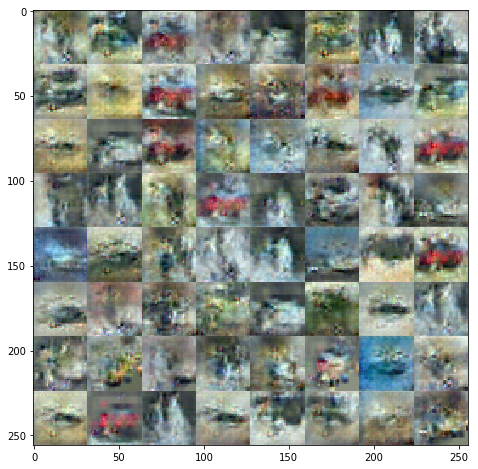

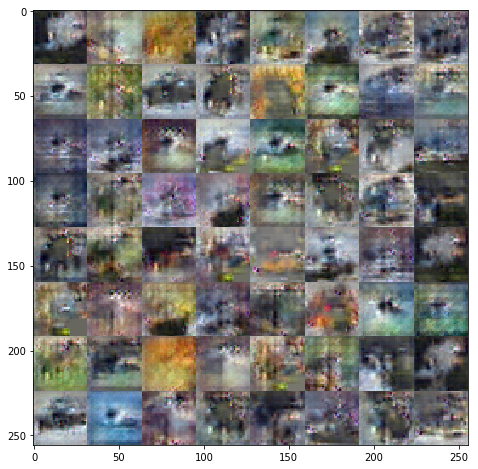

Epoch: [22] [  99/ 600] time: 370.9338, d_loss: 0.14863993, g_loss: 4.53140020


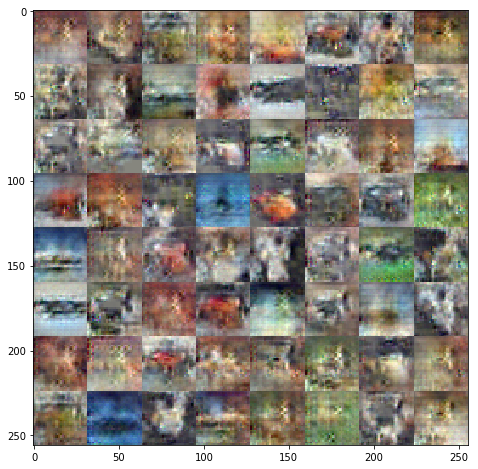

Epoch: [22] [ 199/ 600] time: 399.2957, d_loss: 0.09022775, g_loss: 4.33496237


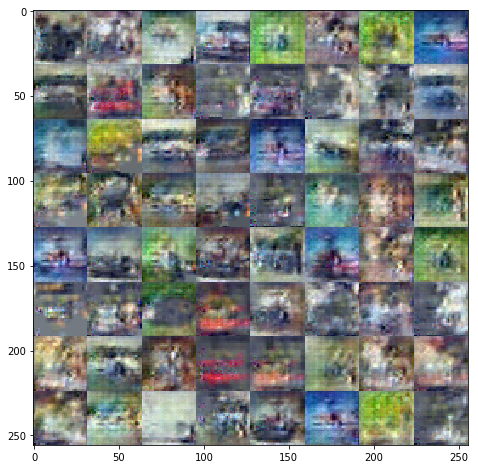

Epoch: [22] [ 299/ 600] time: 427.5979, d_loss: 0.14518423, g_loss: 4.20616388


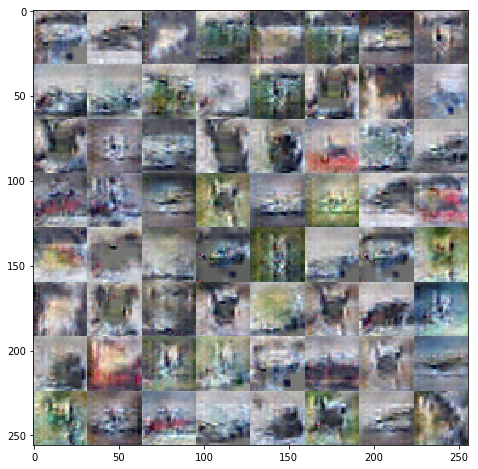

Epoch: [22] [ 399/ 600] time: 455.9346, d_loss: 0.29094905, g_loss: 2.76610136


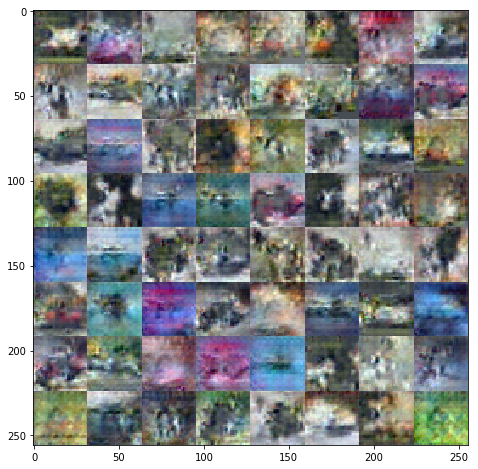

Epoch: [22] [ 499/ 600] time: 484.2870, d_loss: 0.19281651, g_loss: 6.41342115


In [ ]:
# Training Parameters
epoch = 50
batch_size = 100
checkpoint_dir = 'checkpoint'
result_dir = 'results'
log_dir = 'logs'
# open session
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    gan = GAN(sess, epoch=epoch, batch_size=batch_size,
                checkpoint_dir=checkpoint_dir, result_dir=result_dir, log_dir=log_dir)
    # build graph
    gan.build_model()

    # show network architecture
    show_all_variables()

    # launch the graph in a session
    gan.train()
    print(" [*] Training finished!")

    # visualize learned generator
    gan.visualize_results(gan.epoch-1)
    print(" [*] Testing finished!")
